### Plot Shapley values as a function of the distance from the linker COM

1. Read dataset to get fragment, linker and anchor indices (those should be saved separately)
2. Read Shapley values (on disk)
3. Read final positions after diffusion (on disk)
4. Compute linker COM
5. Compute distances fragemtn atoms - linker COM
6. Plot scatterplot Shapley values/distance

In [1]:
import os
os.environ["http_proxy"] = "http://web-proxy.informatik.uni-bonn.de:3128"
os.environ["https_proxy"] = "http://web-proxy.informatik.uni-bonn.de:3128"

In [2]:
import yaml

import torch
import numpy as np

from src.lightning import DDPM
from src.datasets import get_dataloader

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
SAVE_PLOT_FOLDER = "results/plots_COM_addition/"
SHAPLEY_VALUES_FOLDER = "results/shapley_values/"
POSITIONS_FOLDER = "trajectories/zinc_difflinker/zinc_final_test/"


os.makedirs(SAVE_PLOT_FOLDER, exist_ok=True)

with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

checkpoint = config['CHECKPOINT']
DATA = config['DATA']
prefix = config['PREFIX']
device = config['DEVICE'] if torch.cuda.is_available() else 'cpu'
NUM_SAMPLES = config['NUM_SAMPLES']
P = config['P']

Load model to load the data

In [4]:
model = DDPM.load_from_checkpoint(checkpoint, map_location=device)
model.val_data_prefix = prefix

print(f"Running device: {device}")

if DATA is not None:
    model.data_path = DATA

model = model.eval().to(device)
model.setup(stage='val')
dataloader = get_dataloader(
    model.val_dataset,
    batch_size=1
)

Lightning automatically upgraded your loaded checkpoint from v1.6.3 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint z:\Repositories\DiffSHAPer\difflinker\models\zinc_difflinker.ckpt`


Running device: cpu


Load data samples for fragment, linker and anchor indices

In [5]:
data_list = []
sampled = 0
data_dict = {}
for data in dataloader:
    if sampled < NUM_SAMPLES:
        data_list.append(data)
        sampled += 1

#print all fragment masks, linker masks, and anchor masks
for i in range(len(data_list)):
    data_dict[i] = {}
    data_dict[i]["fragment_mask"] = data_list[i]['fragment_mask'].squeeze(0)
    data_dict[i]["linker_mask"] = data_list[i]['linker_mask'].squeeze(0)
    data_dict[i]["anchors"] = data_list[i]['anchors'].squeeze(0)


### Analyze Shapley values

Read Shapley values from disk

In [6]:
seed_list = [42]
STRATEGY = "hausdorff_distance"
for seed in seed_list:
    for i in range(NUM_SAMPLES):
        with open(f"{SHAPLEY_VALUES_FOLDER}explanations_{STRATEGY}_{P}_seed_{str(seed)}_no_transform_transformation_seed_42_COM_addition/phi_atoms_{i}.txt", "r") as f:
            f.readline()
            f.readline()
            shapley_values = []
            for line in f:
                if line == "\n":
                    break
                row = line.strip().split(",")
                shapley_values.append(float(row[1]))
            dict_key_name = f"shapley_values_{seed}"
            data_dict[i][dict_key_name] = shapley_values


read final positions from disk

In [7]:
for seed in seed_list:
    for i in range(NUM_SAMPLES):
        with open(f"{POSITIONS_FOLDER}final_states_{STRATEGY}_{P}_seed_{str(seed)}_no_transform_transformation_seed_42_COM_addition/{i}_pred_.xyz", "r") as f:
            num_atoms = int(f.readline().strip())
            f.readline()
            positions = []*num_atoms
            for line in f:
                row = line.strip().split(" ")[1:]
                coords = [float(x) for x in row]
                positions.append(coords)
            dict_key_name = f"positions_{seed}"
            data_dict[i][dict_key_name] = positions

            

Compute center of mass of linker atoms

In [8]:
for i in range(len(data_list)):
    linker_mask = data_dict[i]['linker_mask'].bool().cpu().numpy()
    for seed in seed_list:
        dict_key_name = f"positions_{seed}"
        positions = np.array(data_dict[i][dict_key_name])
        linker_positions = positions[linker_mask.squeeze()]
        com_linker = np.mean(linker_positions, axis=0)
        dict_key_name = f"com_linker_{seed}"
        data_dict[i][dict_key_name] = com_linker



Compute distance between fragment atoms and center of mass of linker

In [9]:
for i in range(len(data_list)):
    fragment_mask = data_dict[i]['fragment_mask'].bool().cpu().numpy()
    # fragment_positions = np.array(data_dict[i]['positions_14085'])[fragment_mask.squeeze()]
    for seed in seed_list:
        fragment_positions = np.array(data_dict[i][f'positions_{seed}'])[fragment_mask.squeeze()]
        com_linker = data_dict[i][f'com_linker_{seed}']
        distances = np.linalg.norm(fragment_positions - com_linker, axis=1)
        dict_key_name = f'distances_{seed}'
        data_dict[i][dict_key_name] = distances


Scatter plot Shapley values/distance from linker COM

In [10]:
for i in range(len(data_list)):
    for seed in seed_list:
        dict_key_name = f"shapley_values_{seed}"
        shapley_values = -np.array(data_dict[i][dict_key_name])
        min_val = np.min(shapley_values)
        max_val = np.max(shapley_values)
        normalized_shapley_values = 2 * (shapley_values - min_val) / (max_val - min_val) - 1
        dict_key_name = f"normalized_shapley_values_{seed}"
        data_dict[i][dict_key_name] = normalized_shapley_values.tolist()

In [11]:
for i in range(len(data_list)):
    for seed in seed_list:
        dict_key_name = f'distances_{seed}'
        distances = np.array(data_dict[i][dict_key_name])
        min_dist = np.min(distances)
        max_dist = np.max(distances)
        normalized_distances = (distances - min_dist) / (max_dist - min_dist)
        dict_key_name = f'normalized_distances_{seed}'
        data_dict[i][dict_key_name] = normalized_distances.tolist()

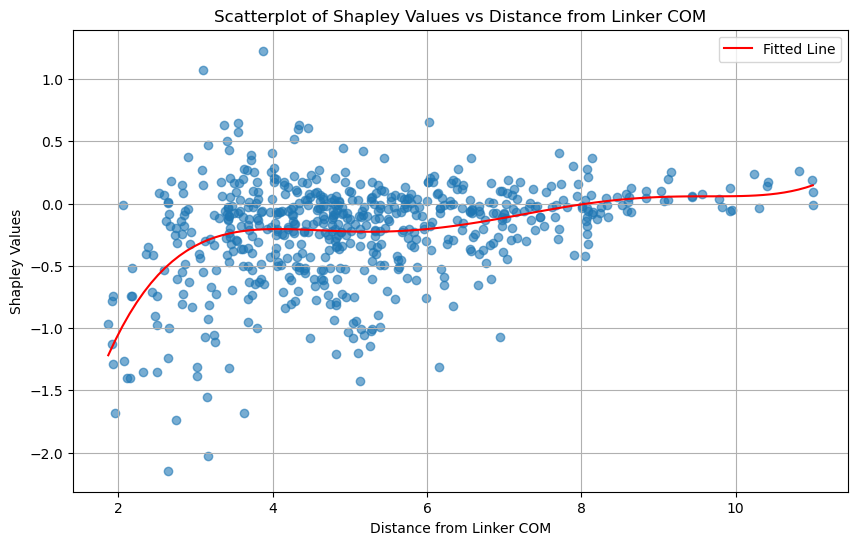

In [12]:
all_distances = []
all_shapley_values = []


for i in range(len(data_list)):
    for seed in seed_list:
        distances = data_dict[i][f'distances_{seed}']
        # normalized_distances = data_dict[i][f'normalized_distances_{seed}']
        shapley_values = data_dict[i][f'shapley_values_{seed}']
        all_distances.extend(distances)
        all_shapley_values.extend(shapley_values)

# Fit a line to the data
coefficients = np.polyfit(all_distances, all_shapley_values, 5)
polynomial = np.poly1d(coefficients)
x_fit = np.linspace(min(all_distances), max(all_distances), 100)
y_fit = polynomial(x_fit)

plt.figure(figsize=(10, 6))
plt.scatter(all_distances, all_shapley_values, alpha=0.6)
plt.plot(x_fit, y_fit, color='red', label='Fitted Line')
plt.xlabel('Distance from Linker COM')
plt.ylabel('Shapley Values')
plt.title('Scatterplot of Shapley Values vs Distance from Linker COM')
plt.legend()
plt.grid(True)
plt.show()

Highlighting anchor atoms

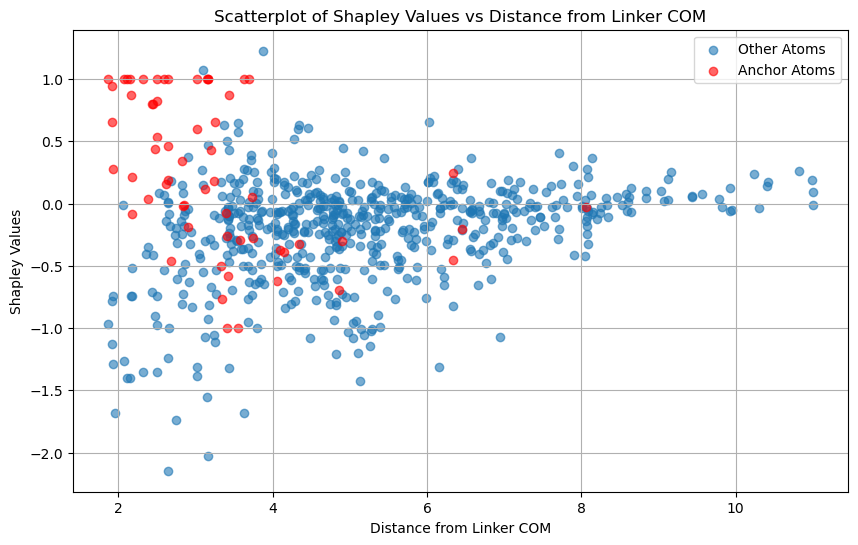

In [13]:
anchor_distances = []
anchor_shapley_values = []

for i in range(len(data_list)):
    for seed in seed_list:
        anchor_mask = data_dict[i]['anchors'].bool().cpu().numpy()
        fragment_mask = data_dict[i]['fragment_mask'].bool().cpu().numpy()
        anchor_mask = anchor_mask[fragment_mask]
        distances = np.array(data_dict[i][f'distances_{seed}'])
        shapley_values = np.array(data_dict[i][f'normalized_shapley_values_{seed}'])
        anchor_distances.extend(distances[anchor_mask])
        anchor_shapley_values.extend(shapley_values[anchor_mask])

plt.figure(figsize=(10, 6))
plt.scatter(all_distances, all_shapley_values, alpha=0.6, label='Other Atoms')
plt.scatter(anchor_distances, anchor_shapley_values, color='red', alpha=0.6, label='Anchor Atoms')
plt.xlabel('Distance from Linker COM')
plt.ylabel('Shapley Values')
plt.title('Scatterplot of Shapley Values vs Distance from Linker COM')
plt.legend()
plt.grid(True)
plt.show()

Box-plot showing normalized Shapley values for anchor atoms and non-anchor atoms

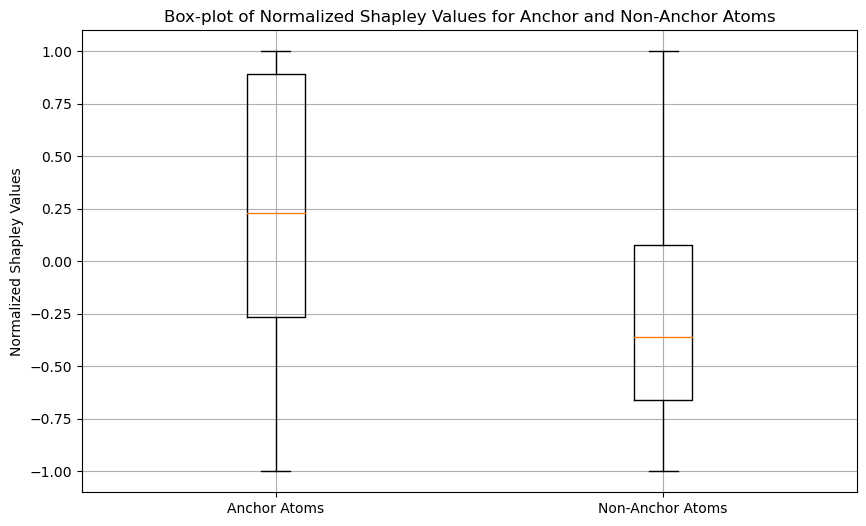

In [14]:
# Prepare data for box plot
anchor_shapley_values = []
non_anchor_shapley_values = []


for i in range(len(data_list)):
    for seed in seed_list:
        anchor_mask = data_dict[i]['anchors'].bool().cpu().numpy()
        fragment_mask = data_dict[i]['fragment_mask'].bool().cpu().numpy()
        anchor_mask = anchor_mask[fragment_mask]
        shapley_values = np.array(data_dict[i][f'normalized_shapley_values_{seed}'])
        anchor_shapley_values.extend(shapley_values[anchor_mask])
        non_anchor_shapley_values.extend(shapley_values[~anchor_mask])

# Create box plot
plt.figure(figsize=(10, 6))
plt.boxplot([anchor_shapley_values, non_anchor_shapley_values], labels=['Anchor Atoms', 'Non-Anchor Atoms'])
plt.ylabel('Normalized Shapley Values')
plt.title('Box-plot of Normalized Shapley Values for Anchor and Non-Anchor Atoms')
plt.grid(True)
plt.show()

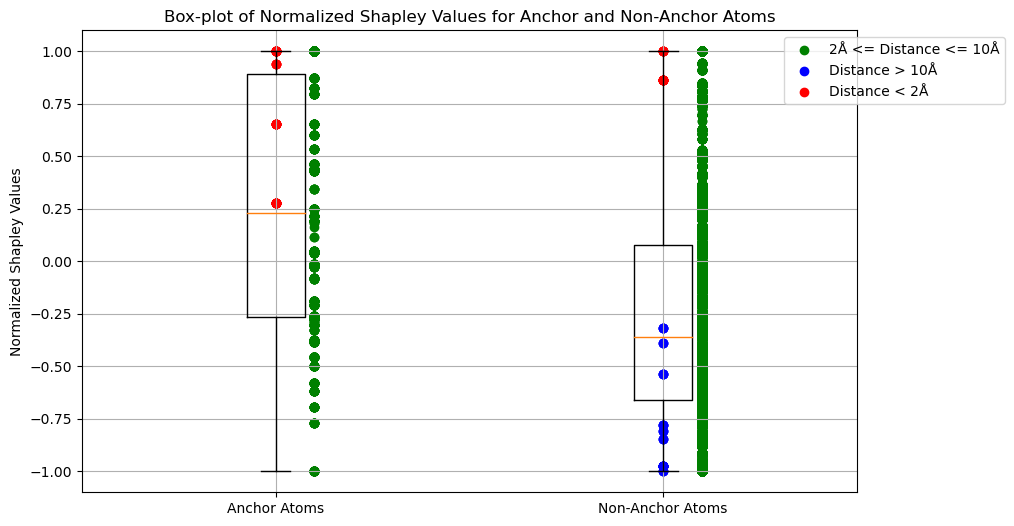

In [15]:
# Prepare data for box plot
anchor_shapley_values = []
distances_anchor = []
non_anchor_shapley_values = []
distances_non_anchor = []
highlighted_shapley_values_close = []
highlighted_shapley_values_far = []

highlighted_shapley_values_close_non_anchor = []
highlighted_shapley_values_far_non_anchor = []

highlighted_middle_shapley_values = []
highlighted_middle_shapley_values_non_anchor = []

threshold_close = 2  # Define the threshold for distance
threshold_close_non_anchor = 2
threshold_far = 10


for i in range(len(data_list)):
    for seed in seed_list:
        anchor_mask = data_dict[i]['anchors'].bool().cpu().numpy()
        fragment_mask = data_dict[i]['fragment_mask'].bool().cpu().numpy()
        anchor_mask = anchor_mask[fragment_mask]
        distances = np.array(data_dict[i][f'distances_{seed}'])
        shapley_values = np.array(data_dict[i][f'normalized_shapley_values_{seed}'])
        
        anchor_shapley_values.extend(shapley_values[anchor_mask])
        distances_anchor.extend(distances[anchor_mask])
        non_anchor_shapley_values.extend(shapley_values[~anchor_mask])
        distances_non_anchor.extend(distances[~anchor_mask])
        # Highlight atoms whose distance is lower than the threshold for anchor atoms
        highlighted_shapley_values_close.extend(np.array(anchor_shapley_values)[np.array(distances_anchor) < threshold_close])
        highlighted_shapley_values_far.extend(np.array(anchor_shapley_values)[np.array(distances_anchor) > threshold_far])

        # Highlight atoms whose distance is lower than the threshold for non-anchor atoms
        highlighted_shapley_values_close_non_anchor.extend(np.array(non_anchor_shapley_values)[np.array(distances_non_anchor) <= threshold_close_non_anchor])
        highlighted_shapley_values_far_non_anchor.extend(np.array(non_anchor_shapley_values)[np.array(distances_non_anchor) >= threshold_far])

        # Highlight atoms whose distance is in the middle
        highlighted_middle_shapley_values.extend(np.array(anchor_shapley_values)[(np.array(distances_anchor) > threshold_close) & (np.array(distances_anchor) < threshold_far)])
        highlighted_middle_shapley_values_non_anchor.extend(np.array(non_anchor_shapley_values)[(np.array(distances_non_anchor) > threshold_close_non_anchor) & (np.array(distances_non_anchor) < threshold_far)])


# Create box plot
plt.figure(figsize=(10, 6))
plt.boxplot([anchor_shapley_values, non_anchor_shapley_values], labels=['Anchor Atoms', 'Non-Anchor Atoms'])

plt.scatter([1.1] * len(highlighted_middle_shapley_values), highlighted_middle_shapley_values, color='green', label='2Å <= Distance <= 10Å')
plt.scatter([1] * len(highlighted_shapley_values_far), highlighted_shapley_values_far, color='blue', label='Distance > 10Å')
plt.scatter([1] * len(highlighted_shapley_values_close), highlighted_shapley_values_close, color='red', label='Distance < 2Å')

plt.scatter([2.1] * len(highlighted_middle_shapley_values_non_anchor), highlighted_middle_shapley_values_non_anchor, color='green')
plt.scatter([2] * len(highlighted_shapley_values_far_non_anchor), highlighted_shapley_values_far_non_anchor, color='blue')
plt.scatter([2] * len(highlighted_shapley_values_close_non_anchor), highlighted_shapley_values_close_non_anchor, color='red')


plt.ylabel('Normalized Shapley Values')
plt.title('Box-plot of Normalized Shapley Values for Anchor and Non-Anchor Atoms')
plt.legend(loc='upper right', bbox_to_anchor=(1.20, 1))
plt.grid(True)
plt.show()

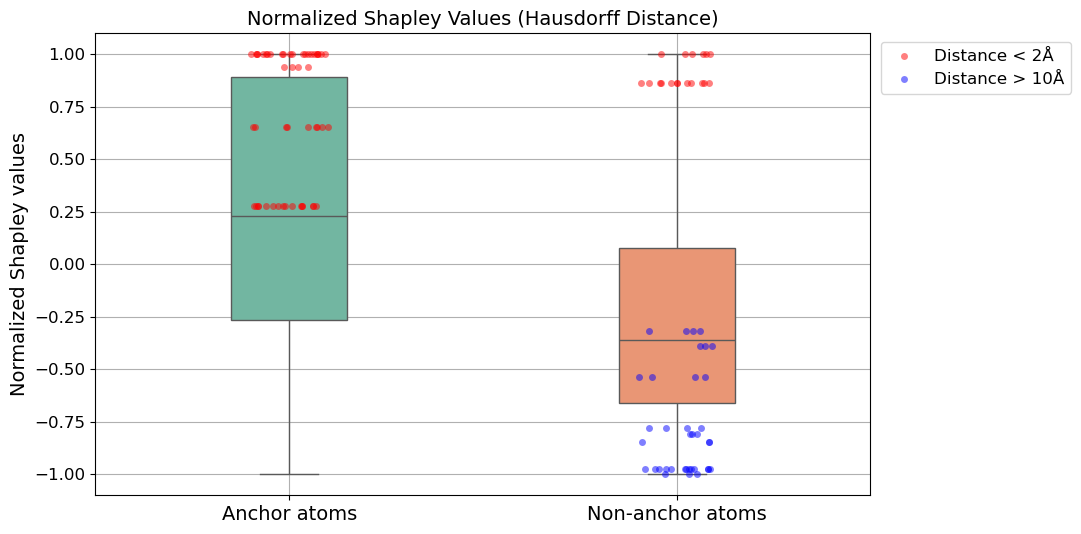

In [16]:
#using seaborn
# Prepare data for box plot
anchor_shapley_values = []
distances_anchor = []
non_anchor_shapley_values = []
distances_non_anchor = []
highlighted_shapley_values_close = []
highlighted_shapley_values_far = []

highlighted_shapley_values_close_non_anchor = []
highlighted_shapley_values_far_non_anchor = []

highlighted_middle_shapley_values = []
highlighted_middle_shapley_values_non_anchor = []

threshold_close = 2  # Define the threshold for distance
threshold_close_non_anchor = 2
threshold_far = 10

for i in range(len(data_list)):
    for seed in seed_list:
        anchor_mask = data_dict[i]['anchors'].bool().cpu().numpy()
        fragment_mask = data_dict[i]['fragment_mask'].bool().cpu().numpy()
        anchor_mask = anchor_mask[fragment_mask]
        distances = np.array(data_dict[i][f'distances_{seed}'])
        shapley_values = np.array(data_dict[i][f'normalized_shapley_values_{seed}'])
        
        anchor_shapley_values.extend(shapley_values[anchor_mask])
        distances_anchor.extend(distances[anchor_mask])
        non_anchor_shapley_values.extend(shapley_values[~anchor_mask])
        distances_non_anchor.extend(distances[~anchor_mask])
        # Highlight atoms whose distance is lower than the threshold for anchor atoms
        highlighted_shapley_values_close.extend(np.array(anchor_shapley_values)[np.array(distances_anchor) < threshold_close])
        highlighted_shapley_values_far.extend(np.array(anchor_shapley_values)[np.array(distances_anchor) > threshold_far])

        # Highlight atoms whose distance is lower than the threshold for non-anchor atoms
        highlighted_shapley_values_close_non_anchor.extend(np.array(non_anchor_shapley_values)[np.array(distances_non_anchor) <= threshold_close_non_anchor])
        highlighted_shapley_values_far_non_anchor.extend(np.array(non_anchor_shapley_values)[np.array(distances_non_anchor) >= threshold_far])

        # Highlight atoms whose distance is in the middle
        highlighted_middle_shapley_values.extend(np.array(anchor_shapley_values)[(np.array(distances_anchor) > threshold_close) & (np.array(distances_anchor) < threshold_far)])
        highlighted_middle_shapley_values_non_anchor.extend(np.array(non_anchor_shapley_values)[(np.array(distances_non_anchor) > threshold_close_non_anchor) & (np.array(distances_non_anchor) < threshold_far)])

# Create box plot using seaborn

plt.figure(figsize=(10, 6))
sns.boxplot(data=[anchor_shapley_values, non_anchor_shapley_values], palette="Set2", width=0.3)
sns.stripplot(data=[highlighted_shapley_values_close, highlighted_shapley_values_close_non_anchor], color='red', alpha=0.5, label='Distance < 2Å')
sns.stripplot(data=[highlighted_shapley_values_far, highlighted_shapley_values_far_non_anchor], color='blue', alpha=0.5, label='Distance > 10Å')

# plt.scatter([0.2] * len(highlighted_middle_shapley_values), highlighted_middle_shapley_values, color='green', alpha=0.5, label='2Å <= Distance <= 10Å', s=20)
# plt.scatter([1.2] * len(highlighted_middle_shapley_values_non_anchor), highlighted_middle_shapley_values_non_anchor, color='green', alpha=0.5, s=20)

plt.xticks([0, 1], ['Anchor atoms', 'Non-anchor atoms'], fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel('Normalized Shapley values', fontsize=14)
plt.title('Normalized Shapley Values (Hausdorff Distance)', fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()

# Filter out the duplicate labels
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

# Set the legend again with the filtered handles and labels
plt.legend(unique_handles, unique_labels, loc='upper right', bbox_to_anchor=(1.27, 1), fontsize=12)

plt.grid(True)
plt.savefig(f"{SAVE_PLOT_FOLDER}box_plot_shapley_values_hausdorff_seed_42_no_green_font_14.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{SAVE_PLOT_FOLDER}box_plot_shapley_values_hausdorff_seed_42_no_green_font_14.png", bbox_inches='tight', dpi=300)


### Shapley value analysis after transformations
Using seed 42 with rotation with seed 42

In [17]:
seed = 42
transform_seed_list = [42]
for t_seed in transform_seed_list:
    for i in range(NUM_SAMPLES):
        with open(f"{SHAPLEY_VALUES_FOLDER}explanations_{STRATEGY}_{P}_seed_{str(seed)}_rotate_translate_reflect_transformation_seed_{str(t_seed)}_COM_addition/phi_atoms_{i}.txt", "r") as f:
            f.readline()
            f.readline()
            shapley_values = []
            for line in f:
                if line == "\n":
                    break
                row = line.strip().split(",")
                shapley_values.append(float(row[1]))
            dict_key_name = f"shapley_values_{t_seed}"
            data_dict[i][dict_key_name] = shapley_values

In [18]:
for t_seed in transform_seed_list:
    for i in range(NUM_SAMPLES):
        with open(f"{POSITIONS_FOLDER}final_states_{STRATEGY}_{P}_seed_{str(seed)}_rotate_translate_reflect_transformation_seed_{str(t_seed)}_COM_addition/{i}_pred_.xyz", "r") as f:
            num_atoms = int(f.readline().strip())
            f.readline()
            positions = []*num_atoms
            for line in f:
                row = line.strip().split(" ")[1:]
                coords = [float(x) for x in row]
                positions.append(coords)
            dict_key_name = f"positions_{t_seed}"
            data_dict[i][dict_key_name] = positions

In [19]:
for i in range(len(data_list)):
    linker_mask = data_dict[i]['linker_mask'].bool().cpu().numpy()
    for t_seed in transform_seed_list:
        dict_key_name = f"positions_{t_seed}"
        positions = np.array(data_dict[i][dict_key_name])
        linker_positions = positions[linker_mask.squeeze()]
        com_linker = np.mean(linker_positions, axis=0)
        dict_key_name = f"com_linker_{t_seed}"
        data_dict[i][dict_key_name] = com_linker


In [20]:
for i in range(len(data_list)):
    fragment_mask = data_dict[i]['fragment_mask'].bool().cpu().numpy()
    
    for t_seed in transform_seed_list:
        fragment_positions = np.array(data_dict[i][f'positions_{seed}'])[fragment_mask.squeeze()]
        com_linker = data_dict[i][f'com_linker_{t_seed}']
        distances = np.linalg.norm(fragment_positions - com_linker, axis=1)
        dict_key_name = f'distances_{t_seed}'
        data_dict[i][dict_key_name] = distances



In [21]:
for i in range(len(data_list)):
    for t_seed in transform_seed_list:
        dict_key_name = f"shapley_values_{t_seed}"
        shapley_values = -np.array(data_dict[i][dict_key_name])
        min_val = np.min(shapley_values)
        max_val = np.max(shapley_values)
        normalized_shapley_values = 2 * (shapley_values - min_val) / (max_val - min_val) - 1
        dict_key_name = f"normalized_shapley_values_{t_seed}"
        data_dict[i][dict_key_name] = normalized_shapley_values.tolist()

Number of anchor atoms: 60
Number of non-anchor atoms: 550
Total number of atoms: 610
Number of highlighted atoms close to the linker COM: 51
Number of highlighted atoms far from the linker COM: 0
Number of highlighted atoms close to the linker COM for non-anchor atoms: 18
Number of highlighted atoms far from the linker COM for non-anchor atoms: 20
Number of highlighted atoms in the middle for anchor atoms: 879
Number of highlighted atoms in the middle for non-anchor atoms: 8299
Total number of highlighted atoms: 9267


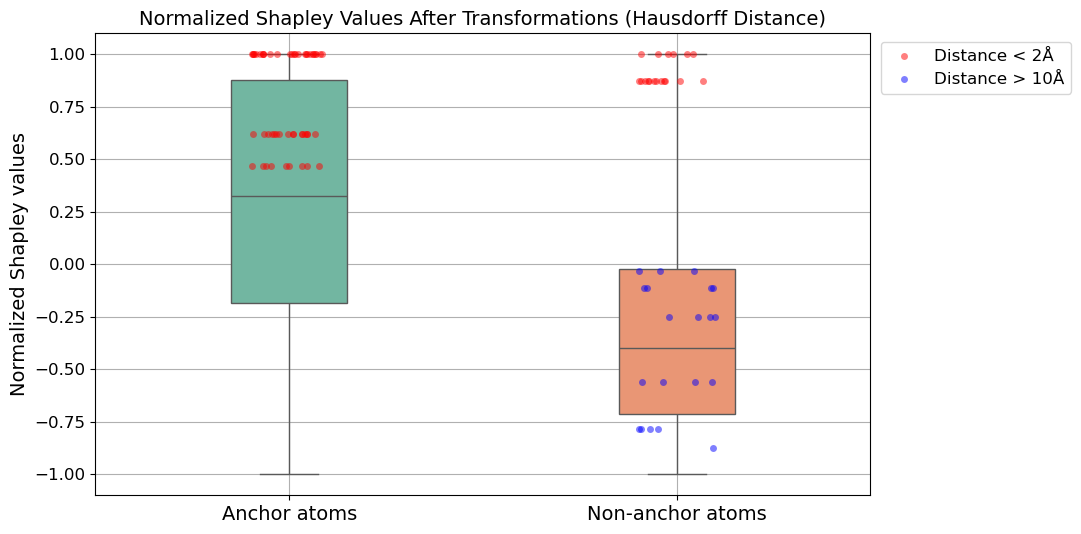

In [22]:
# Prepare data for box plot
anchor_shapley_values = []
distances_anchor = []
non_anchor_shapley_values = []
distances_non_anchor = []
highlighted_shapley_values_close = []
highlighted_shapley_values_far = []

highlighted_shapley_values_close_non_anchor = []
highlighted_shapley_values_far_non_anchor = []

highlighted_middle_shapley_values = []
highlighted_middle_shapley_values_non_anchor = []

threshold_close = 2  # Define the threshold for distance
threshold_close_non_anchor = 2
threshold_far = 10

for i in range(len(data_list)):
    for t_seed in transform_seed_list:
        anchor_mask = data_dict[i]['anchors'].bool().cpu().numpy()
        fragment_mask = data_dict[i]['fragment_mask'].bool().cpu().numpy()
        anchor_mask = anchor_mask[fragment_mask]
        distances = np.array(data_dict[i][f'distances_{t_seed}'])
        shapley_values = np.array(data_dict[i][f'normalized_shapley_values_{t_seed}'])
        
        anchor_shapley_values.extend(shapley_values[anchor_mask])
        distances_anchor.extend(distances[anchor_mask])
        non_anchor_shapley_values.extend(shapley_values[~anchor_mask])
        distances_non_anchor.extend(distances[~anchor_mask])
        # Highlight atoms whose distance is lower than the threshold for anchor atoms
        highlighted_shapley_values_close.extend(np.array(anchor_shapley_values)[np.array(distances_anchor) < threshold_close])
        highlighted_shapley_values_far.extend(np.array(anchor_shapley_values)[np.array(distances_anchor) > threshold_far])

        # Highlight atoms whose distance is lower than the threshold for non-anchor atoms
        highlighted_shapley_values_close_non_anchor.extend(np.array(non_anchor_shapley_values)[np.array(distances_non_anchor) <= threshold_close_non_anchor])
        highlighted_shapley_values_far_non_anchor.extend(np.array(non_anchor_shapley_values)[np.array(distances_non_anchor) >= threshold_far])

        # Highlight atoms whose distance is in the middle
        highlighted_middle_shapley_values.extend(np.array(anchor_shapley_values)[(np.array(distances_anchor) > threshold_close) & (np.array(distances_anchor) < threshold_far)])
        highlighted_middle_shapley_values_non_anchor.extend(np.array(non_anchor_shapley_values)[(np.array(distances_non_anchor) > threshold_close_non_anchor) & (np.array(distances_non_anchor) < threshold_far)])

print("Number of anchor atoms:", len(anchor_shapley_values))
print("Number of non-anchor atoms:", len(non_anchor_shapley_values))
print("Total number of atoms:", len(anchor_shapley_values) + len(non_anchor_shapley_values))

print("Number of highlighted atoms close to the linker COM:", len(highlighted_shapley_values_close))
print("Number of highlighted atoms far from the linker COM:", len(highlighted_shapley_values_far))

print("Number of highlighted atoms close to the linker COM for non-anchor atoms:", len(highlighted_shapley_values_close_non_anchor))
print("Number of highlighted atoms far from the linker COM for non-anchor atoms:", len(highlighted_shapley_values_far_non_anchor))

print("Number of highlighted atoms in the middle for anchor atoms:", len(highlighted_middle_shapley_values))
print("Number of highlighted atoms in the middle for non-anchor atoms:", len(highlighted_middle_shapley_values_non_anchor))

print("Total number of highlighted atoms:", len(highlighted_shapley_values_close) + len(highlighted_shapley_values_far) + len(highlighted_shapley_values_close_non_anchor) + len(highlighted_shapley_values_far_non_anchor) + len(highlighted_middle_shapley_values) + len(highlighted_middle_shapley_values_non_anchor))
# Create box plot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=[anchor_shapley_values, non_anchor_shapley_values], palette="Set2", width=0.3)
# sns.stripplot(data=[anchor_shapley_values, non_anchor_shapley_values], color='black', alpha=0.5)
sns.stripplot(data=[highlighted_shapley_values_close, highlighted_shapley_values_close_non_anchor], color='red', alpha=0.5, label='Distance < 2Å')

sns.stripplot(data=[highlighted_shapley_values_far, highlighted_shapley_values_far_non_anchor], color='blue', alpha=0.5, label='Distance > 10Å')

# plt.scatter([0.2] * len(highlighted_middle_shapley_values), highlighted_middle_shapley_values, color='green', alpha=0.5, label='2Å <= Distance <= 10Å', s=20)
# plt.scatter([0] * len(highlighted_shapley_values_far), highlighted_shapley_values_far, color='blue', label='Distance > 10Å')
# plt.scatter([0] * len(highlighted_shapley_values_close), highlighted_shapley_values_close, color='red', label='Distance < 2Å')

# plt.scatter([1.2] * len(highlighted_middle_shapley_values_non_anchor), highlighted_middle_shapley_values_non_anchor, color='green', alpha=0.5, s=20)
# plt.scatter([1] * len(highlighted_shapley_values_far_non_anchor), highlighted_shapley_values_far_non_anchor, color='blue')
# plt.scatter([1] * len(highlighted_shapley_values_close_non_anchor), highlighted_shapley_values_close_non_anchor, color='red')

plt.xticks([0, 1], ['Anchor atoms', 'Non-anchor atoms'], fontsize=14)
plt.ylabel('Normalized Shapley values', fontsize=14)
plt.yticks(fontsize=12)
plt.title('Normalized Shapley Values After Transformations (Hausdorff Distance)', fontsize=14)
# plt.title('Box-plot of Normalized Shapley Values for Anchor and Non-Anchor Atoms (After Transformations)')

handles, labels = plt.gca().get_legend_handles_labels()

# Filter out the duplicate labels
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

# Set the legend again with the filtered handles and labels
plt.legend(unique_handles, unique_labels, loc='upper right', bbox_to_anchor=(1.27, 1), fontsize=12)

plt.grid(True)
# plt.show()
plt.savefig(f"{SAVE_PLOT_FOLDER}box_plot_shapley_values_hausdorff_after_transform_all_transform_seed_42_no_green_font_14.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{SAVE_PLOT_FOLDER}box_plot_shapley_values_hausdorff_after_transform_all_transform_seed_42_no_green_font_14.png", bbox_inches='tight', dpi=300)

### Analysis of Shapley values for the Coulomb matrix of the full molecule using Monte Carlo generated molecules

We reinstatiate and reload data to avoid inconistencies and errors.

Load data samples for fragment, linker and anchor indices

In [23]:
data_list = []
sampled = 0
data_dict = {}
for data in dataloader:
    if sampled < NUM_SAMPLES:
        data_list.append(data)
        sampled += 1

#print all fragment masks, linker masks, and anchor masks
for i in range(len(data_list)):
    data_dict[i] = {}
    data_dict[i]["fragment_mask"] = data_list[i]['fragment_mask'].squeeze(0)
    data_dict[i]["linker_mask"] = data_list[i]['linker_mask'].squeeze(0)
    data_dict[i]["anchors"] = data_list[i]['anchors'].squeeze(0)


Read Shapley values from disk

In [24]:
seed_list = [42]
STRATEGY = "coulomb_matrix_full_molecule_monte_carlo"
for seed in seed_list:
    for i in range(NUM_SAMPLES):
        with open(f"{SHAPLEY_VALUES_FOLDER}explanations_{STRATEGY}_{P}_seed_{str(seed)}/phi_atoms_{i}.txt", "r") as f:
            f.readline()
            f.readline()
            shapley_values = []
            for line in f:
                if line == "\n":
                    break
                row = line.strip().split(",")
                shapley_values.append(float(row[1]))
            dict_key_name = f"shapley_values_{seed}"
            data_dict[i][dict_key_name] = shapley_values
        with open(f"{SHAPLEY_VALUES_FOLDER}explanations_{STRATEGY}_{P}_seed_{str(seed)}/phi_atoms_{i}.txt", "r") as f:
            frobenius_norm_original = None
            frobenius_norm_average = None
            found = False
            while not found:
                line = f.readline()
                if line.startswith("Original linker frobenius norm"):
                    frobenius_norm_original = float(line.strip().split(":")[1])
                if line.startswith("Average frobenius norm random samples"):
                    frobenius_norm_average = float(line.strip().split(":")[1])
                if frobenius_norm_original is not None and frobenius_norm_average is not None:
                    found = True    
            dict_key_name = f"frobenius_norm_original_{seed}"
            data_dict[i][dict_key_name] = frobenius_norm_original
            dict_key_name = f"frobenius_norm_average_{seed}"
            data_dict[i][dict_key_name] = frobenius_norm_average
            


read final positions from disk

In [25]:
for seed in seed_list:
    for i in range(NUM_SAMPLES):
        with open(f"{POSITIONS_FOLDER}final_states_{STRATEGY}_{P}_seed_{str(seed)}/{i}_pred_.xyz", "r") as f:
            num_atoms = int(f.readline().strip())
            f.readline()
            positions = []*num_atoms
            for line in f:
                row = line.strip().split(" ")[1:]
                coords = [float(x) for x in row]
                positions.append(coords)
            dict_key_name = f"positions_{seed}"
            data_dict[i][dict_key_name] = positions

Compute center of mass of linker atoms

In [26]:
for i in range(len(data_list)):
    linker_mask = data_dict[i]['linker_mask'].bool().cpu().numpy()
    for seed in seed_list:
        dict_key_name = f"positions_{seed}"
        positions = np.array(data_dict[i][dict_key_name])
        linker_positions = positions[linker_mask.squeeze()]
        com_linker = np.mean(linker_positions, axis=0)
        dict_key_name = f"com_linker_{seed}"
        data_dict[i][dict_key_name] = com_linker



In [27]:
for i in range(len(data_list)):
    fragment_mask = data_dict[i]['fragment_mask'].bool().cpu().numpy()
    
    for seed in seed_list:
        fragment_positions = np.array(data_dict[i][f'positions_{seed}'])[fragment_mask.squeeze()]
        com_linker = data_dict[i][f'com_linker_{seed}']
        distances = np.linalg.norm(fragment_positions - com_linker, axis=1)
        dict_key_name = f'distances_{seed}'
        data_dict[i][dict_key_name] = distances


Scatter plot Shapley values/distance from linker COM

In [28]:
for i in range(len(data_list)):
    for seed in seed_list:
        dict_key_name = f"shapley_values_{seed}"
        avg_frobenius_norm = data_dict[i][f"frobenius_norm_average_{seed}"]
        original_frobenius_norm = data_dict[i][f"frobenius_norm_original_{seed}"]
        if avg_frobenius_norm > original_frobenius_norm:
            shapley_values = -np.array(data_dict[i][dict_key_name])
        else:
            shapley_values = np.array(data_dict[i][dict_key_name])
        min_val = np.min(shapley_values)
        max_val = np.max(shapley_values)
        normalized_shapley_values = 2 * (shapley_values - min_val) / (max_val - min_val) - 1
        dict_key_name = f"normalized_shapley_values_{seed}"
        data_dict[i][dict_key_name] = normalized_shapley_values.tolist()

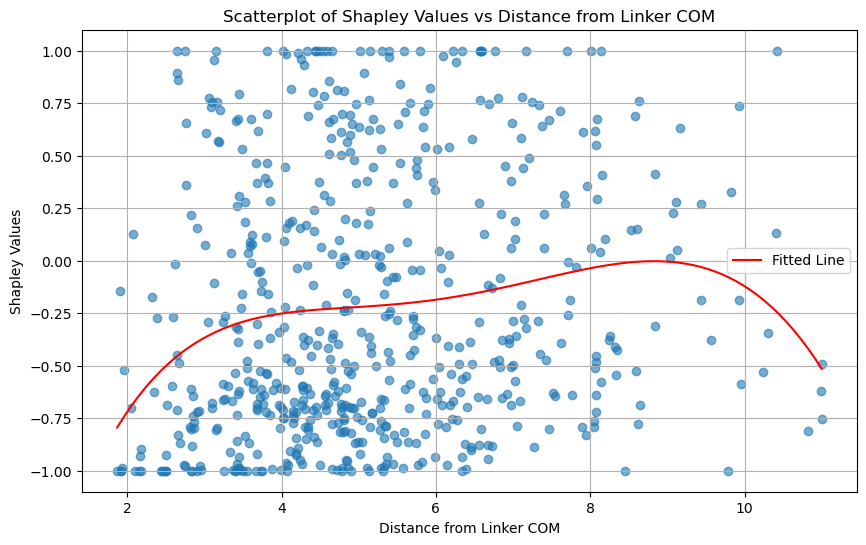

In [29]:
all_distances = []
all_shapley_values = []


for i in range(len(data_list)):
    for seed in seed_list:
        distances = data_dict[i][f'distances_{seed}']
        # normalized_distances = data_dict[i][f'normalized_distances_{seed}']
        shapley_values = data_dict[i][f'normalized_shapley_values_{seed}']
        all_distances.extend(distances)
        all_shapley_values.extend(shapley_values)

# Fit a line to the data
coefficients = np.polyfit(all_distances, all_shapley_values, 5)
polynomial = np.poly1d(coefficients)
x_fit = np.linspace(min(all_distances), max(all_distances), 100)
y_fit = polynomial(x_fit)

plt.figure(figsize=(10, 6))
plt.scatter(all_distances, all_shapley_values, alpha=0.6)
plt.plot(x_fit, y_fit, color='red', label='Fitted Line')
plt.xlabel('Distance from Linker COM')
plt.ylabel('Shapley Values')
plt.title('Scatterplot of Shapley Values vs Distance from Linker COM')
plt.legend()
plt.grid(True)
plt.show()

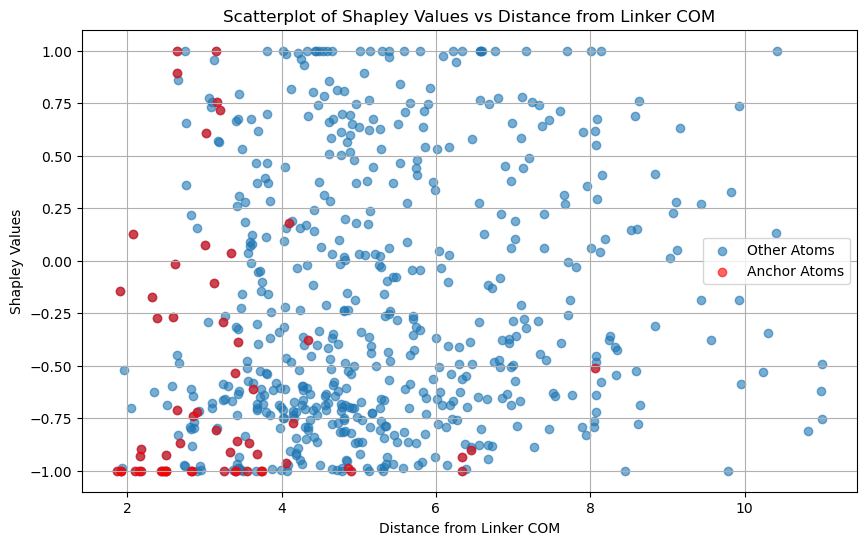

In [30]:
anchor_distances = []
anchor_shapley_values = []

for i in range(len(data_list)):
    for seed in seed_list:
        anchor_mask = data_dict[i]['anchors'].bool().cpu().numpy()
        fragment_mask = data_dict[i]['fragment_mask'].bool().cpu().numpy()
        anchor_mask = anchor_mask[fragment_mask]
        distances = np.array(data_dict[i][f'distances_{seed}'])
        shapley_values = np.array(data_dict[i][f'normalized_shapley_values_{seed}'])
        anchor_distances.extend(distances[anchor_mask])
        anchor_shapley_values.extend(shapley_values[anchor_mask])

plt.figure(figsize=(10, 6))
plt.scatter(all_distances, all_shapley_values, alpha=0.6, label='Other Atoms')
plt.scatter(anchor_distances, anchor_shapley_values, color='red', alpha=0.6, label='Anchor Atoms')
plt.xlabel('Distance from Linker COM')
plt.ylabel('Shapley Values')
plt.title('Scatterplot of Shapley Values vs Distance from Linker COM')
plt.legend()
plt.grid(True)
plt.show()

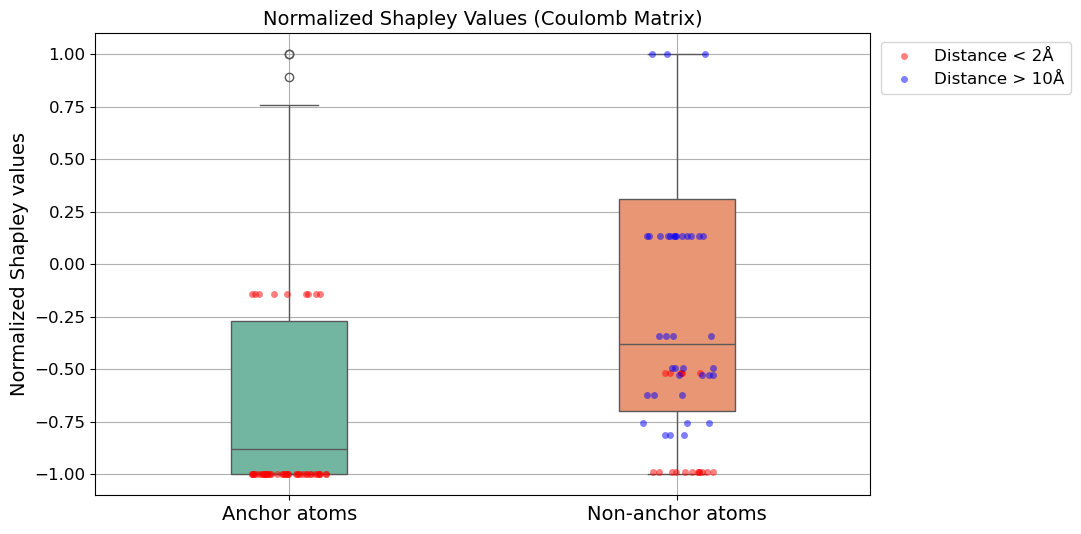

In [31]:
#using seaborn
# Prepare data for box plot
anchor_shapley_values = []
distances_anchor = []
non_anchor_shapley_values = []
distances_non_anchor = []
highlighted_shapley_values_close = []
highlighted_shapley_values_far = []

highlighted_shapley_values_close_non_anchor = []
highlighted_shapley_values_far_non_anchor = []

highlighted_middle_shapley_values = []
highlighted_middle_shapley_values_non_anchor = []

threshold_close = 2  # Define the threshold for distance
threshold_close_non_anchor = 2
threshold_far = 10

for i in range(len(data_list)):
    for seed in seed_list:
        anchor_mask = data_dict[i]['anchors'].bool().cpu().numpy()
        fragment_mask = data_dict[i]['fragment_mask'].bool().cpu().numpy()
        anchor_mask = anchor_mask[fragment_mask]
        distances = np.array(data_dict[i][f'distances_{seed}'])
        shapley_values = np.array(data_dict[i][f'normalized_shapley_values_{seed}'])
        
        anchor_shapley_values.extend(shapley_values[anchor_mask])
        distances_anchor.extend(distances[anchor_mask])
        non_anchor_shapley_values.extend(shapley_values[~anchor_mask])
        distances_non_anchor.extend(distances[~anchor_mask])
        # Highlight atoms whose distance is lower than the threshold for anchor atoms
        highlighted_shapley_values_close.extend(np.array(anchor_shapley_values)[np.array(distances_anchor) < threshold_close])
        highlighted_shapley_values_far.extend(np.array(anchor_shapley_values)[np.array(distances_anchor) > threshold_far])

        # Highlight atoms whose distance is lower than the threshold for non-anchor atoms
        highlighted_shapley_values_close_non_anchor.extend(np.array(non_anchor_shapley_values)[np.array(distances_non_anchor) <= threshold_close_non_anchor])
        highlighted_shapley_values_far_non_anchor.extend(np.array(non_anchor_shapley_values)[np.array(distances_non_anchor) >= threshold_far])

        # Highlight atoms whose distance is in the middle
        highlighted_middle_shapley_values.extend(np.array(anchor_shapley_values)[(np.array(distances_anchor) > threshold_close) & (np.array(distances_anchor) < threshold_far)])
        highlighted_middle_shapley_values_non_anchor.extend(np.array(non_anchor_shapley_values)[(np.array(distances_non_anchor) > threshold_close_non_anchor) & (np.array(distances_non_anchor) < threshold_far)])

# Create box plot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=[anchor_shapley_values, non_anchor_shapley_values], palette="Set2", width=0.3)
sns.stripplot(data=[highlighted_shapley_values_close, highlighted_shapley_values_close_non_anchor], color='red', alpha=0.5, label='Distance < 2Å')
sns.stripplot(data=[highlighted_shapley_values_far, highlighted_shapley_values_far_non_anchor], color='blue', alpha=0.5, label='Distance > 10Å')

# plt.scatter([0.2] * len(highlighted_middle_shapley_values), highlighted_middle_shapley_values, color='green', alpha=0.5, label='2Å <= Distance <= 10Å', s=20)
# plt.scatter([1.2] * len(highlighted_middle_shapley_values_non_anchor), highlighted_middle_shapley_values_non_anchor, color='green', alpha=0.5, s=20)

plt.xticks([0, 1], ['Anchor atoms', 'Non-anchor atoms'], fontsize=14)
plt.ylabel('Normalized Shapley values', fontsize=14)
plt.yticks(fontsize=12)
plt.title('Normalized Shapley Values (Coulomb Matrix)', fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()

# Filter out the duplicate labels
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

# Set the legend again with the filtered handles and labels
plt.legend(unique_handles, unique_labels, loc='upper right', bbox_to_anchor=(1.27, 1), fontsize=12)

plt.grid(True)
plt.savefig(f"{SAVE_PLOT_FOLDER}box_plot_shapley_values_coulomb_matrix_full_molecule_monte_carlo_seed_42_no_green_font_14.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{SAVE_PLOT_FOLDER}box_plot_shapley_values_coulomb_matrix_full_molecule_monte_carlo_seed_42_no_green_font_14.png", bbox_inches='tight', dpi=300)



### Analysis of Shapley values for the Coulomb matrix of the whole molecule using Monte Carlo generated molecules after transformations


In [32]:
seed = 42
transform_seed_list = [42]
for t_seed in transform_seed_list:
    for i in range(NUM_SAMPLES):
        with open(f"{SHAPLEY_VALUES_FOLDER}explanations_{STRATEGY}_{P}_seed_{str(seed)}_rotate_translate_reflect_transformation_seed_{str(t_seed)}/phi_atoms_{i}.txt", "r") as f:
            f.readline()
            f.readline()
            shapley_values = []
            for line in f:
                if line == "\n":
                    break
                row = line.strip().split(",")
                shapley_values.append(float(row[1]))
            dict_key_name = f"shapley_values_{t_seed}"
            data_dict[i][dict_key_name] = shapley_values
        with open(f"{SHAPLEY_VALUES_FOLDER}explanations_{STRATEGY}_{P}_seed_{str(seed)}/phi_atoms_{i}.txt", "r") as f:
            frobenius_norm_original = None
            frobenius_norm_average = None
            found = False
            while not found:
                line = f.readline()
                if line.startswith("Original linker frobenius norm"):
                    frobenius_norm_original = float(line.strip().split(":")[1])
                if line.startswith("Average frobenius norm random samples"):
                    frobenius_norm_average = float(line.strip().split(":")[1])
                if frobenius_norm_original is not None and frobenius_norm_average is not None:
                    found = True    
            dict_key_name = f"frobenius_norm_original_{seed}"
            data_dict[i][dict_key_name] = frobenius_norm_original
            dict_key_name = f"frobenius_norm_average_{seed}"
            data_dict[i][dict_key_name] = frobenius_norm_average

In [33]:
for t_seed in transform_seed_list:
    for i in range(NUM_SAMPLES):
        with open(f"{POSITIONS_FOLDER}final_states_{STRATEGY}_{P}_seed_{str(seed)}_rotate_translate_reflect_transformation_seed_{str(t_seed)}/{i}_pred_.xyz", "r") as f:
            num_atoms = int(f.readline().strip())
            f.readline()
            positions = []*num_atoms
            for line in f:
                row = line.strip().split(" ")[1:]
                coords = [float(x) for x in row]
                positions.append(coords)
            dict_key_name = f"positions_{t_seed}"
            data_dict[i][dict_key_name] = positions

In [34]:
for i in range(len(data_list)):
    linker_mask = data_dict[i]['linker_mask'].bool().cpu().numpy()
    for t_seed in transform_seed_list:
        dict_key_name = f"positions_{t_seed}"
        positions = np.array(data_dict[i][dict_key_name])
        linker_positions = positions[linker_mask.squeeze()]
        com_linker = np.mean(linker_positions, axis=0)
        dict_key_name = f"com_linker_{t_seed}"
        data_dict[i][dict_key_name] = com_linker


In [35]:
for i in range(len(data_list)):
    fragment_mask = data_dict[i]['fragment_mask'].bool().cpu().numpy()
    
    for t_seed in transform_seed_list:
        fragment_positions = np.array(data_dict[i][f'positions_{seed}'])[fragment_mask.squeeze()]
        com_linker = data_dict[i][f'com_linker_{t_seed}']
        distances = np.linalg.norm(fragment_positions - com_linker, axis=1)
        dict_key_name = f'distances_{t_seed}'
        data_dict[i][dict_key_name] = distances


In [36]:
for i in range(len(data_list)):
    for t_seed in transform_seed_list:
        dict_key_name = f"shapley_values_{t_seed}"
        avg_frobenius_norm = data_dict[i][f"frobenius_norm_average_{seed}"]
        original_frobenius_norm = data_dict[i][f"frobenius_norm_original_{seed}"]
        if avg_frobenius_norm > original_frobenius_norm:
            shapley_values = -np.array(data_dict[i][dict_key_name])
        else:
            shapley_values = np.array(data_dict[i][dict_key_name])
        shapley_values = -np.array(data_dict[i][dict_key_name])
        min_val = np.min(shapley_values)
        max_val = np.max(shapley_values)
        normalized_shapley_values = 2 * (shapley_values - min_val) / (max_val - min_val) - 1
        dict_key_name = f"normalized_shapley_values_{t_seed}"
        data_dict[i][dict_key_name] = normalized_shapley_values.tolist()

Number of anchor atoms: 60
Number of non-anchor atoms: 550
Total number of atoms: 610
Number of highlighted atoms close to the linker COM: 51
Number of highlighted atoms far from the linker COM: 0
Number of highlighted atoms close to the linker COM for non-anchor atoms: 18
Number of highlighted atoms far from the linker COM for non-anchor atoms: 20
Number of highlighted atoms in the middle for anchor atoms: 879
Number of highlighted atoms in the middle for non-anchor atoms: 8299
Total number of highlighted atoms: 9267


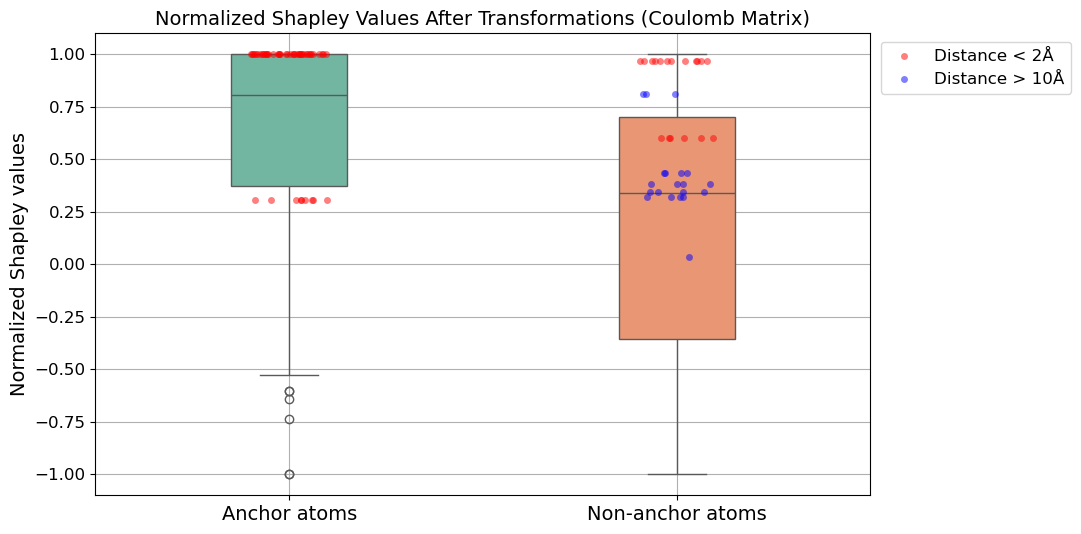

In [37]:
# Prepare data for box plot
anchor_shapley_values = []
distances_anchor = []
non_anchor_shapley_values = []
distances_non_anchor = []
highlighted_shapley_values_close = []
highlighted_shapley_values_far = []

highlighted_shapley_values_close_non_anchor = []
highlighted_shapley_values_far_non_anchor = []

highlighted_middle_shapley_values = []
highlighted_middle_shapley_values_non_anchor = []

threshold_close = 2  # Define the threshold for distance
threshold_close_non_anchor = 2
threshold_far = 10

for i in range(len(data_list)):
    for t_seed in transform_seed_list:
        anchor_mask = data_dict[i]['anchors'].bool().cpu().numpy()
        fragment_mask = data_dict[i]['fragment_mask'].bool().cpu().numpy()
        anchor_mask = anchor_mask[fragment_mask]
        distances = np.array(data_dict[i][f'distances_{t_seed}'])
        shapley_values = np.array(data_dict[i][f'normalized_shapley_values_{t_seed}'])
        
        anchor_shapley_values.extend(shapley_values[anchor_mask])
        distances_anchor.extend(distances[anchor_mask])
        non_anchor_shapley_values.extend(shapley_values[~anchor_mask])
        distances_non_anchor.extend(distances[~anchor_mask])
        # Highlight atoms whose distance is lower than the threshold for anchor atoms
        highlighted_shapley_values_close.extend(np.array(anchor_shapley_values)[np.array(distances_anchor) < threshold_close])
        highlighted_shapley_values_far.extend(np.array(anchor_shapley_values)[np.array(distances_anchor) > threshold_far])

        # Highlight atoms whose distance is lower than the threshold for non-anchor atoms
        highlighted_shapley_values_close_non_anchor.extend(np.array(non_anchor_shapley_values)[np.array(distances_non_anchor) <= threshold_close_non_anchor])
        highlighted_shapley_values_far_non_anchor.extend(np.array(non_anchor_shapley_values)[np.array(distances_non_anchor) >= threshold_far])

        # Highlight atoms whose distance is in the middle
        highlighted_middle_shapley_values.extend(np.array(anchor_shapley_values)[(np.array(distances_anchor) > threshold_close) & (np.array(distances_anchor) < threshold_far)])
        highlighted_middle_shapley_values_non_anchor.extend(np.array(non_anchor_shapley_values)[(np.array(distances_non_anchor) > threshold_close_non_anchor) & (np.array(distances_non_anchor) < threshold_far)])

print("Number of anchor atoms:", len(anchor_shapley_values))
print("Number of non-anchor atoms:", len(non_anchor_shapley_values))
print("Total number of atoms:", len(anchor_shapley_values) + len(non_anchor_shapley_values))

print("Number of highlighted atoms close to the linker COM:", len(highlighted_shapley_values_close))
print("Number of highlighted atoms far from the linker COM:", len(highlighted_shapley_values_far))

print("Number of highlighted atoms close to the linker COM for non-anchor atoms:", len(highlighted_shapley_values_close_non_anchor))
print("Number of highlighted atoms far from the linker COM for non-anchor atoms:", len(highlighted_shapley_values_far_non_anchor))

print("Number of highlighted atoms in the middle for anchor atoms:", len(highlighted_middle_shapley_values))
print("Number of highlighted atoms in the middle for non-anchor atoms:", len(highlighted_middle_shapley_values_non_anchor))

print("Total number of highlighted atoms:", len(highlighted_shapley_values_close) + len(highlighted_shapley_values_far) + len(highlighted_shapley_values_close_non_anchor) + len(highlighted_shapley_values_far_non_anchor) + len(highlighted_middle_shapley_values) + len(highlighted_middle_shapley_values_non_anchor))
# Create box plot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=[anchor_shapley_values, non_anchor_shapley_values], palette="Set2", width=0.3)
# sns.stripplot(data=[anchor_shapley_values, non_anchor_shapley_values], color='black', alpha=0.5)
sns.stripplot(data=[highlighted_shapley_values_close, highlighted_shapley_values_close_non_anchor], color='red', alpha=0.5, label='Distance < 2Å')

sns.stripplot(data=[highlighted_shapley_values_far, highlighted_shapley_values_far_non_anchor], color='blue', alpha=0.5, label='Distance > 10Å')

# plt.scatter([0.2] * len(highlighted_middle_shapley_values), highlighted_middle_shapley_values, color='green', alpha=0.5, label='2Å <= Distance <= 10Å', s=20)
# # plt.scatter([0] * len(highlighted_shapley_values_far), highlighted_shapley_values_far, color='blue', label='Distance > 10Å')
# # plt.scatter([0] * len(highlighted_shapley_values_close), highlighted_shapley_values_close, color='red', label='Distance < 2Å')

# plt.scatter([1.2] * len(highlighted_middle_shapley_values_non_anchor), highlighted_middle_shapley_values_non_anchor, color='green', alpha=0.5, s=20)
# plt.scatter([1] * len(highlighted_shapley_values_far_non_anchor), highlighted_shapley_values_far_non_anchor, color='blue')
# plt.scatter([1] * len(highlighted_shapley_values_close_non_anchor), highlighted_shapley_values_close_non_anchor, color='red')

plt.xticks([0, 1], ['Anchor atoms', 'Non-anchor atoms'], fontsize=14)
plt.ylabel('Normalized Shapley values' , fontsize=14)
plt.yticks(fontsize=12)
plt.title('Normalized Shapley Values After Transformations (Coulomb Matrix)', fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()

# Filter out the duplicate labels
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

# Set the legend again with the filtered handles and labels
plt.legend(unique_handles, unique_labels, loc='upper right', bbox_to_anchor=(1.27, 1), fontsize=12)

plt.grid(True)
# plt.show()
plt.savefig(f"{SAVE_PLOT_FOLDER}box_plot_shapley_values_coulomb_matrix_full_molecule_monte_carlo_after_transform_all_transform_42_no_green_font_14.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{SAVE_PLOT_FOLDER}box_plot_shapley_values_coulomb_matrix_full_molecule_monte_carlo_after_transform_all_transform_42_no_green_font_14.png", bbox_inches='tight', dpi=300)

### Analysis of Shapley values for the Coulomb matrix of the whole molecule
Ideally, the imporatnce here should not depend on distance (only)

We reinstatiate and reload data to avoid inconistencies and errors.

Load data samples for fragment, linker and anchor indices

In [38]:
data_list = []
sampled = 0
data_dict = {}
for data in dataloader:
    if sampled < NUM_SAMPLES:
        data_list.append(data)
        sampled += 1

#print all fragment masks, linker masks, and anchor masks
for i in range(len(data_list)):
    data_dict[i] = {}
    data_dict[i]["fragment_mask"] = data_list[i]['fragment_mask'].squeeze(0)
    data_dict[i]["linker_mask"] = data_list[i]['linker_mask'].squeeze(0)
    data_dict[i]["anchors"] = data_list[i]['anchors'].squeeze(0)


Read Shapley values from disk

In [39]:
seed_list = [42]
STRATEGY = "coulomb_matrix_full_molecule_original_fragments"
for seed in seed_list:
    for i in range(NUM_SAMPLES):
        with open(f"{SHAPLEY_VALUES_FOLDER}explanations_{STRATEGY}_{P}_seed_{str(seed)}/phi_atoms_{i}.txt", "r") as f:
            f.readline()
            f.readline()
            shapley_values = []
            for line in f:
                if line == "\n":
                    break
                row = line.strip().split(",")
                shapley_values.append(float(row[1]))
            dict_key_name = f"shapley_values_{seed}"
            data_dict[i][dict_key_name] = shapley_values
        with open(f"{SHAPLEY_VALUES_FOLDER}explanations_{STRATEGY}_{P}_seed_{str(seed)}/phi_atoms_{i}.txt", "r") as f:
            frobenius_norm_original = None
            frobenius_norm_average = None
            found = False
            while not found:
                line = f.readline()
                if line.startswith("Frobenius norm of original molecule"):
                    frobenius_norm_original = float(line.strip().split(":")[1])
                if line.startswith("Average Frobenius norm of random samples"):
                    frobenius_norm_average = float(line.strip().split(":")[1])
                if frobenius_norm_original is not None and frobenius_norm_average is not None:
                    found = True    
            dict_key_name = f"frobenius_norm_original_{seed}"
            data_dict[i][dict_key_name] = frobenius_norm_original
            dict_key_name = f"frobenius_norm_average_{seed}"
            data_dict[i][dict_key_name] = frobenius_norm_average
            


read final positions from disk

In [40]:
for seed in seed_list:
    for i in range(NUM_SAMPLES):
        with open(f"{POSITIONS_FOLDER}final_states_{STRATEGY}_{P}_seed_{str(seed)}/{i}_pred_.xyz", "r") as f:
            num_atoms = int(f.readline().strip())
            f.readline()
            positions = []*num_atoms
            for line in f:
                row = line.strip().split(" ")[1:]
                coords = [float(x) for x in row]
                positions.append(coords)
            dict_key_name = f"positions_{seed}"
            data_dict[i][dict_key_name] = positions

Compute center of mass of linker atoms

In [41]:
for i in range(len(data_list)):
    linker_mask = data_dict[i]['linker_mask'].bool().cpu().numpy()
    for seed in seed_list:
        dict_key_name = f"positions_{seed}"
        positions = np.array(data_dict[i][dict_key_name])
        linker_positions = positions[linker_mask.squeeze()]
        com_linker = np.mean(linker_positions, axis=0)
        dict_key_name = f"com_linker_{seed}"
        data_dict[i][dict_key_name] = com_linker



In [42]:
for i in range(len(data_list)):
    fragment_mask = data_dict[i]['fragment_mask'].bool().cpu().numpy()
    
    for seed in seed_list:
        fragment_positions = np.array(data_dict[i][f'positions_{seed}'])[fragment_mask.squeeze()]
        com_linker = data_dict[i][f'com_linker_{seed}']
        distances = np.linalg.norm(fragment_positions - com_linker, axis=1)
        dict_key_name = f'distances_{seed}'
        data_dict[i][dict_key_name] = distances


Scatter plot Shapley values/distance from linker COM
This needs to be edited. Top Shapley values depend on average value. Need to read from disk and check if inversion of sign is needed as in the Hausdorff case.

In [43]:
for i in range(len(data_list)):
    for seed in seed_list:
        dict_key_name = f"shapley_values_{seed}"
        avg_frobenius_norm = data_dict[i][f"frobenius_norm_average_{seed}"]
        original_frobenius_norm = data_dict[i][f"frobenius_norm_original_{seed}"]
        if avg_frobenius_norm > original_frobenius_norm:
            shapley_values = -np.array(data_dict[i][dict_key_name])
        else:
            shapley_values = np.array(data_dict[i][dict_key_name])
        min_val = np.min(shapley_values)
        max_val = np.max(shapley_values)
        normalized_shapley_values = 2 * (shapley_values - min_val) / (max_val - min_val) - 1
        dict_key_name = f"normalized_shapley_values_{seed}"
        data_dict[i][dict_key_name] = normalized_shapley_values.tolist()

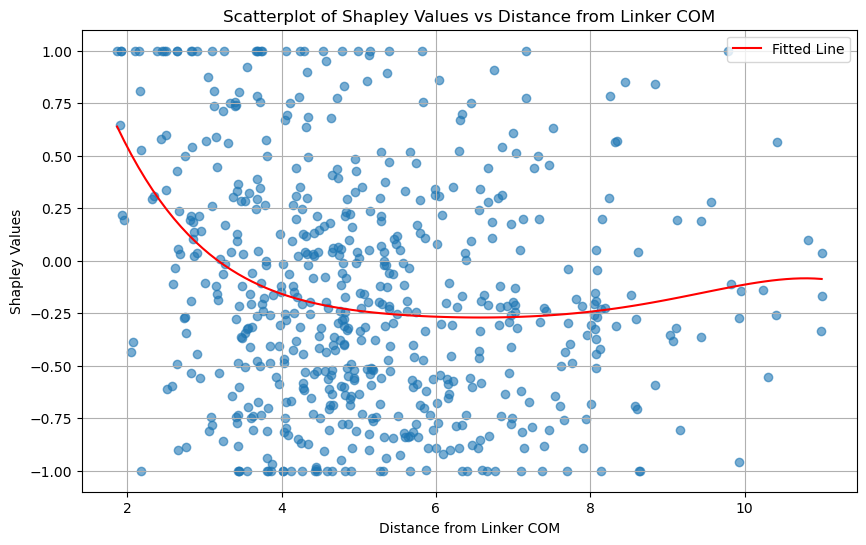

In [44]:
all_distances = []
all_shapley_values = []


for i in range(len(data_list)):
    for seed in seed_list:
        distances = data_dict[i][f'distances_{seed}']
        # normalized_distances = data_dict[i][f'normalized_distances_{seed}']
        shapley_values = data_dict[i][f'normalized_shapley_values_{seed}']
        all_distances.extend(distances)
        all_shapley_values.extend(shapley_values)

# Fit a line to the data
coefficients = np.polyfit(all_distances, all_shapley_values, 5)
polynomial = np.poly1d(coefficients)
x_fit = np.linspace(min(all_distances), max(all_distances), 100)
y_fit = polynomial(x_fit)

plt.figure(figsize=(10, 6))
plt.scatter(all_distances, all_shapley_values, alpha=0.6)
plt.plot(x_fit, y_fit, color='red', label='Fitted Line')
plt.xlabel('Distance from Linker COM')
plt.ylabel('Shapley Values')
plt.title('Scatterplot of Shapley Values vs Distance from Linker COM')
plt.legend()
plt.grid(True)
plt.show()

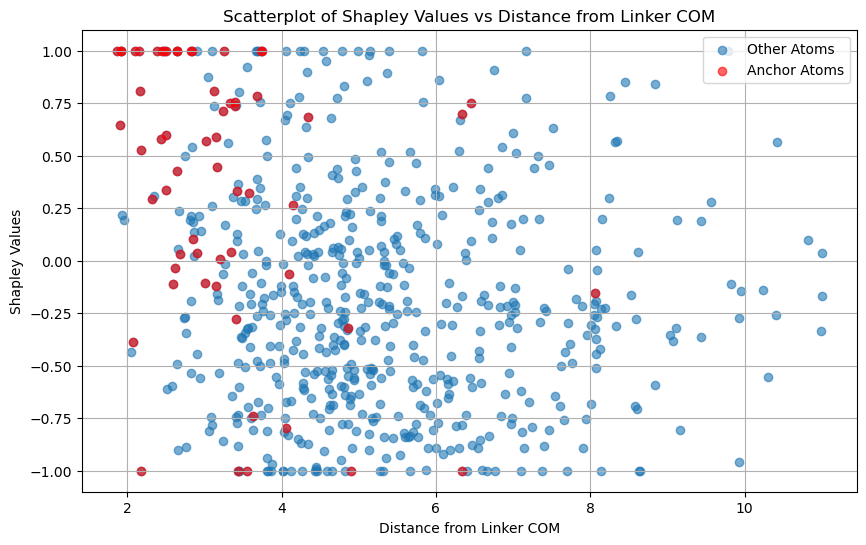

In [45]:
anchor_distances = []
anchor_shapley_values = []

for i in range(len(data_list)):
    for seed in seed_list:
        anchor_mask = data_dict[i]['anchors'].bool().cpu().numpy()
        fragment_mask = data_dict[i]['fragment_mask'].bool().cpu().numpy()
        anchor_mask = anchor_mask[fragment_mask]
        distances = np.array(data_dict[i][f'distances_{seed}'])
        shapley_values = np.array(data_dict[i][f'normalized_shapley_values_{seed}'])
        anchor_distances.extend(distances[anchor_mask])
        anchor_shapley_values.extend(shapley_values[anchor_mask])

plt.figure(figsize=(10, 6))
plt.scatter(all_distances, all_shapley_values, alpha=0.6, label='Other Atoms')
plt.scatter(anchor_distances, anchor_shapley_values, color='red', alpha=0.6, label='Anchor Atoms')
plt.xlabel('Distance from Linker COM')
plt.ylabel('Shapley Values')
plt.title('Scatterplot of Shapley Values vs Distance from Linker COM')
plt.legend()
plt.grid(True)
plt.show()

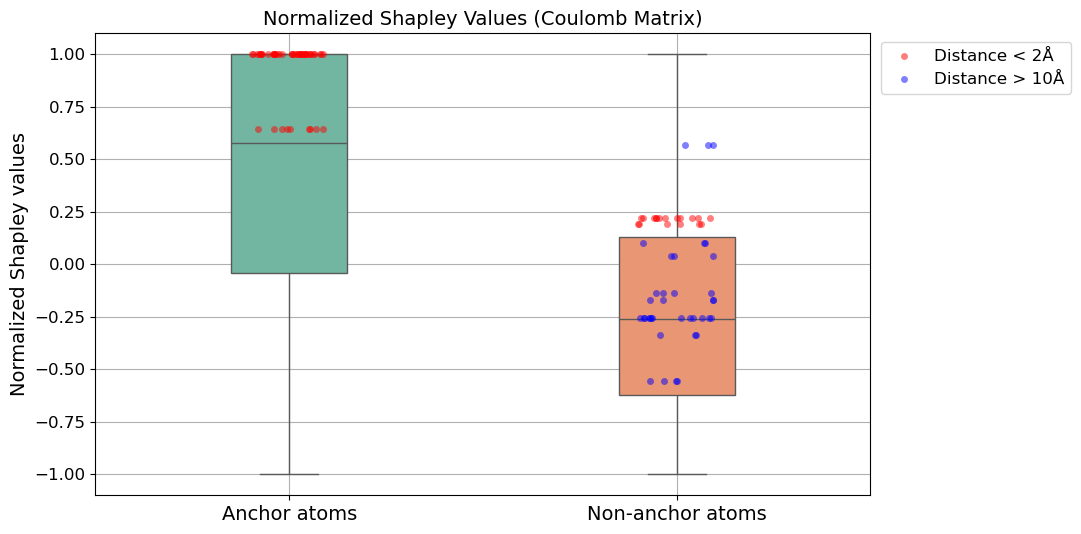

In [46]:
#using seaborn
# Prepare data for box plot
anchor_shapley_values = []
distances_anchor = []
non_anchor_shapley_values = []
distances_non_anchor = []
highlighted_shapley_values_close = []
highlighted_shapley_values_far = []

highlighted_shapley_values_close_non_anchor = []
highlighted_shapley_values_far_non_anchor = []

highlighted_middle_shapley_values = []
highlighted_middle_shapley_values_non_anchor = []

threshold_close = 2  # Define the threshold for distance
threshold_close_non_anchor = 2
threshold_far = 10

for i in range(len(data_list)):
    for seed in seed_list:
        anchor_mask = data_dict[i]['anchors'].bool().cpu().numpy()
        fragment_mask = data_dict[i]['fragment_mask'].bool().cpu().numpy()
        anchor_mask = anchor_mask[fragment_mask]
        distances = np.array(data_dict[i][f'distances_{seed}'])
        shapley_values = np.array(data_dict[i][f'normalized_shapley_values_{seed}'])
        
        anchor_shapley_values.extend(shapley_values[anchor_mask])
        distances_anchor.extend(distances[anchor_mask])
        non_anchor_shapley_values.extend(shapley_values[~anchor_mask])
        distances_non_anchor.extend(distances[~anchor_mask])
        # Highlight atoms whose distance is lower than the threshold for anchor atoms
        highlighted_shapley_values_close.extend(np.array(anchor_shapley_values)[np.array(distances_anchor) < threshold_close])
        highlighted_shapley_values_far.extend(np.array(anchor_shapley_values)[np.array(distances_anchor) > threshold_far])

        # Highlight atoms whose distance is lower than the threshold for non-anchor atoms
        highlighted_shapley_values_close_non_anchor.extend(np.array(non_anchor_shapley_values)[np.array(distances_non_anchor) <= threshold_close_non_anchor])
        highlighted_shapley_values_far_non_anchor.extend(np.array(non_anchor_shapley_values)[np.array(distances_non_anchor) >= threshold_far])

        # Highlight atoms whose distance is in the middle
        highlighted_middle_shapley_values.extend(np.array(anchor_shapley_values)[(np.array(distances_anchor) > threshold_close) & (np.array(distances_anchor) < threshold_far)])
        highlighted_middle_shapley_values_non_anchor.extend(np.array(non_anchor_shapley_values)[(np.array(distances_non_anchor) > threshold_close_non_anchor) & (np.array(distances_non_anchor) < threshold_far)])

# Create box plot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=[anchor_shapley_values, non_anchor_shapley_values], palette="Set2", width=0.3)
sns.stripplot(data=[highlighted_shapley_values_close, highlighted_shapley_values_close_non_anchor], color='red', alpha=0.5, label='Distance < 2Å')
sns.stripplot(data=[highlighted_shapley_values_far, highlighted_shapley_values_far_non_anchor], color='blue', alpha=0.5, label='Distance > 10Å')

# plt.scatter([0.2] * len(highlighted_middle_shapley_values), highlighted_middle_shapley_values, color='green', alpha=0.5, label='2Å <= Distance <= 10Å', s=20)
# plt.scatter([1.2] * len(highlighted_middle_shapley_values_non_anchor), highlighted_middle_shapley_values_non_anchor, color='green', alpha=0.5, s=20)

plt.xticks([0, 1], ['Anchor atoms', 'Non-anchor atoms'], fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel('Normalized Shapley values', fontsize=14)
plt.title('Normalized Shapley Values (Coulomb Matrix)', fontsize=14)
# plt.title('Box-plot of Normalized Shapley Values for Anchor and Non-Anchor Atoms')

handles, labels = plt.gca().get_legend_handles_labels()

# Filter out the duplicate labels
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

# Set the legend again with the filtered handles and labels
plt.legend(unique_handles, unique_labels, loc='upper right', bbox_to_anchor=(1.27, 1), fontsize=12)

plt.grid(True)
plt.savefig(f"{SAVE_PLOT_FOLDER}box_plot_shapley_values_coulomb_matrix_full_molecule_original_fragments_seed_42_no_green_font_14.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{SAVE_PLOT_FOLDER}box_plot_shapley_values_coulomb_matrix_full_molecule_original_fragments_seed_42_no_green_font_14.png", bbox_inches='tight', dpi=300)



### Shapley value analysis for Coulomb Matrix of the whole molecule after transformation

In [47]:
seed = 42
transform_seed_list = [42]
for t_seed in transform_seed_list:
    for i in range(NUM_SAMPLES):
        with open(f"{SHAPLEY_VALUES_FOLDER}explanations_{STRATEGY}_{P}_seed_{str(seed)}_rotate_transformation_seed_{str(t_seed)}/phi_atoms_{i}.txt", "r") as f:
            f.readline()
            f.readline()
            shapley_values = []
            for line in f:
                if line == "\n":
                    break
                row = line.strip().split(",")
                shapley_values.append(float(row[1]))
            dict_key_name = f"shapley_values_{t_seed}"
            data_dict[i][dict_key_name] = shapley_values
        with open(f"{SHAPLEY_VALUES_FOLDER}explanations_{STRATEGY}_{P}_seed_{str(seed)}/phi_atoms_{i}.txt", "r") as f:
            frobenius_norm_original = None
            frobenius_norm_average = None
            found = False
            while not found:
                line = f.readline()
                if line.startswith("Frobenius norm of original molecule"):
                    frobenius_norm_original = float(line.strip().split(":")[1])
                if line.startswith("Average Frobenius norm of random samples"):
                    frobenius_norm_average = float(line.strip().split(":")[1])
                if frobenius_norm_original is not None and frobenius_norm_average is not None:
                    found = True    
            dict_key_name = f"frobenius_norm_original_{seed}"
            data_dict[i][dict_key_name] = frobenius_norm_original
            dict_key_name = f"frobenius_norm_average_{seed}"
            data_dict[i][dict_key_name] = frobenius_norm_average

In [48]:
for t_seed in transform_seed_list:
    for i in range(NUM_SAMPLES):
        with open(f"{POSITIONS_FOLDER}final_states_{STRATEGY}_{P}_seed_{str(seed)}_rotate_transformation_seed_{str(t_seed)}/{i}_pred_.xyz", "r") as f:
            num_atoms = int(f.readline().strip())
            f.readline()
            positions = []*num_atoms
            for line in f:
                row = line.strip().split(" ")[1:]
                coords = [float(x) for x in row]
                positions.append(coords)
            dict_key_name = f"positions_{t_seed}"
            data_dict[i][dict_key_name] = positions

In [49]:
for i in range(len(data_list)):
    linker_mask = data_dict[i]['linker_mask'].bool().cpu().numpy()
    for t_seed in transform_seed_list:
        dict_key_name = f"positions_{t_seed}"
        positions = np.array(data_dict[i][dict_key_name])
        linker_positions = positions[linker_mask.squeeze()]
        com_linker = np.mean(linker_positions, axis=0)
        dict_key_name = f"com_linker_{t_seed}"
        data_dict[i][dict_key_name] = com_linker


In [50]:
for i in range(len(data_list)):
    fragment_mask = data_dict[i]['fragment_mask'].bool().cpu().numpy()
    
    for t_seed in transform_seed_list:
        fragment_positions = np.array(data_dict[i][f'positions_{seed}'])[fragment_mask.squeeze()]
        com_linker = data_dict[i][f'com_linker_{t_seed}']
        distances = np.linalg.norm(fragment_positions - com_linker, axis=1)
        dict_key_name = f'distances_{t_seed}'
        data_dict[i][dict_key_name] = distances


In [51]:
for i in range(len(data_list)):
    for t_seed in transform_seed_list:
        dict_key_name = f"shapley_values_{t_seed}"
        avg_frobenius_norm = data_dict[i][f"frobenius_norm_average_{seed}"]
        original_frobenius_norm = data_dict[i][f"frobenius_norm_original_{seed}"]
        if avg_frobenius_norm > original_frobenius_norm:
            shapley_values = -np.array(data_dict[i][dict_key_name])
        else:
            shapley_values = np.array(data_dict[i][dict_key_name])
        shapley_values = -np.array(data_dict[i][dict_key_name])
        min_val = np.min(shapley_values)
        max_val = np.max(shapley_values)
        normalized_shapley_values = 2 * (shapley_values - min_val) / (max_val - min_val) - 1
        dict_key_name = f"normalized_shapley_values_{t_seed}"
        data_dict[i][dict_key_name] = normalized_shapley_values.tolist()

Number of anchor atoms: 60
Number of non-anchor atoms: 550
Total number of atoms: 610
Number of highlighted atoms close to the linker COM: 51
Number of highlighted atoms far from the linker COM: 0
Number of highlighted atoms close to the linker COM for non-anchor atoms: 18
Number of highlighted atoms far from the linker COM for non-anchor atoms: 16
Number of highlighted atoms in the middle for anchor atoms: 879
Number of highlighted atoms in the middle for non-anchor atoms: 8303
Total number of highlighted atoms: 9267


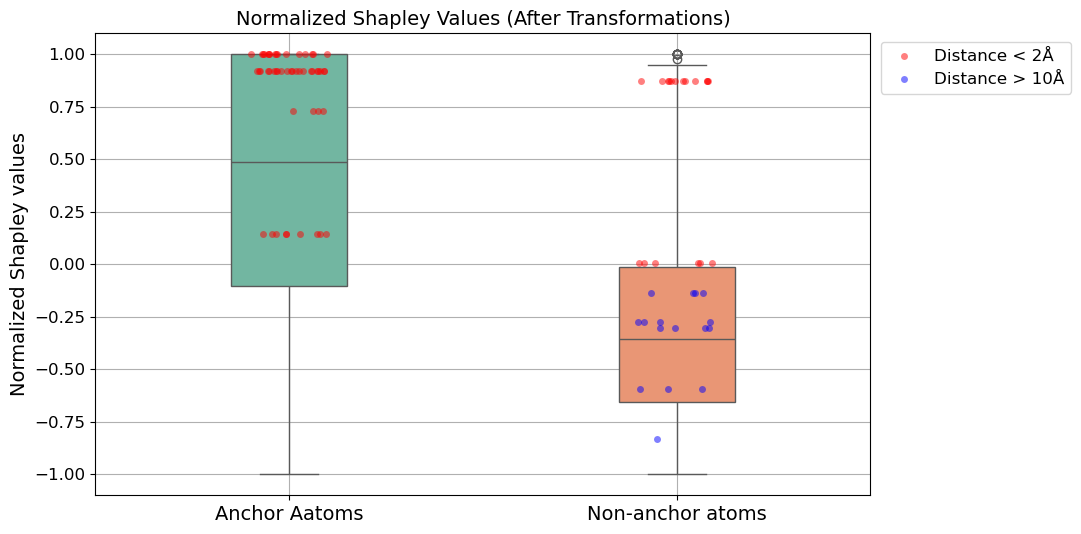

In [52]:
# Prepare data for box plot
anchor_shapley_values = []
distances_anchor = []
non_anchor_shapley_values = []
distances_non_anchor = []
highlighted_shapley_values_close = []
highlighted_shapley_values_far = []

highlighted_shapley_values_close_non_anchor = []
highlighted_shapley_values_far_non_anchor = []

highlighted_middle_shapley_values = []
highlighted_middle_shapley_values_non_anchor = []

threshold_close = 2  # Define the threshold for distance
threshold_close_non_anchor = 2
threshold_far = 10

for i in range(len(data_list)):
    for t_seed in transform_seed_list:
        anchor_mask = data_dict[i]['anchors'].bool().cpu().numpy()
        fragment_mask = data_dict[i]['fragment_mask'].bool().cpu().numpy()
        anchor_mask = anchor_mask[fragment_mask]
        distances = np.array(data_dict[i][f'distances_{t_seed}'])
        shapley_values = np.array(data_dict[i][f'normalized_shapley_values_{t_seed}'])
        
        anchor_shapley_values.extend(shapley_values[anchor_mask])
        distances_anchor.extend(distances[anchor_mask])
        non_anchor_shapley_values.extend(shapley_values[~anchor_mask])
        distances_non_anchor.extend(distances[~anchor_mask])
        # Highlight atoms whose distance is lower than the threshold for anchor atoms
        highlighted_shapley_values_close.extend(np.array(anchor_shapley_values)[np.array(distances_anchor) < threshold_close])
        highlighted_shapley_values_far.extend(np.array(anchor_shapley_values)[np.array(distances_anchor) > threshold_far])

        # Highlight atoms whose distance is lower than the threshold for non-anchor atoms
        highlighted_shapley_values_close_non_anchor.extend(np.array(non_anchor_shapley_values)[np.array(distances_non_anchor) <= threshold_close_non_anchor])
        highlighted_shapley_values_far_non_anchor.extend(np.array(non_anchor_shapley_values)[np.array(distances_non_anchor) >= threshold_far])

        # Highlight atoms whose distance is in the middle
        highlighted_middle_shapley_values.extend(np.array(anchor_shapley_values)[(np.array(distances_anchor) > threshold_close) & (np.array(distances_anchor) < threshold_far)])
        highlighted_middle_shapley_values_non_anchor.extend(np.array(non_anchor_shapley_values)[(np.array(distances_non_anchor) > threshold_close_non_anchor) & (np.array(distances_non_anchor) < threshold_far)])

print("Number of anchor atoms:", len(anchor_shapley_values))
print("Number of non-anchor atoms:", len(non_anchor_shapley_values))
print("Total number of atoms:", len(anchor_shapley_values) + len(non_anchor_shapley_values))

print("Number of highlighted atoms close to the linker COM:", len(highlighted_shapley_values_close))
print("Number of highlighted atoms far from the linker COM:", len(highlighted_shapley_values_far))

print("Number of highlighted atoms close to the linker COM for non-anchor atoms:", len(highlighted_shapley_values_close_non_anchor))
print("Number of highlighted atoms far from the linker COM for non-anchor atoms:", len(highlighted_shapley_values_far_non_anchor))

print("Number of highlighted atoms in the middle for anchor atoms:", len(highlighted_middle_shapley_values))
print("Number of highlighted atoms in the middle for non-anchor atoms:", len(highlighted_middle_shapley_values_non_anchor))

print("Total number of highlighted atoms:", len(highlighted_shapley_values_close) + len(highlighted_shapley_values_far) + len(highlighted_shapley_values_close_non_anchor) + len(highlighted_shapley_values_far_non_anchor) + len(highlighted_middle_shapley_values) + len(highlighted_middle_shapley_values_non_anchor))
# Create box plot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=[anchor_shapley_values, non_anchor_shapley_values], palette="Set2", width=0.3)
# sns.stripplot(data=[anchor_shapley_values, non_anchor_shapley_values], color='black', alpha=0.5)
sns.stripplot(data=[highlighted_shapley_values_close, highlighted_shapley_values_close_non_anchor], color='red', alpha=0.5, label='Distance < 2Å')

sns.stripplot(data=[highlighted_shapley_values_far, highlighted_shapley_values_far_non_anchor], color='blue', alpha=0.5, label='Distance > 10Å')

# plt.scatter([0.2] * len(highlighted_middle_shapley_values), highlighted_middle_shapley_values, color='green', alpha=0.5, label='2Å <= Distance <= 10Å', s=20)
# # plt.scatter([0] * len(highlighted_shapley_values_far), highlighted_shapley_values_far, color='blue', label='Distance > 10Å')
# # plt.scatter([0] * len(highlighted_shapley_values_close), highlighted_shapley_values_close, color='red', label='Distance < 2Å')

# plt.scatter([1.2] * len(highlighted_middle_shapley_values_non_anchor), highlighted_middle_shapley_values_non_anchor, color='green', alpha=0.5, s=20)
# plt.scatter([1] * len(highlighted_shapley_values_far_non_anchor), highlighted_shapley_values_far_non_anchor, color='blue')
# plt.scatter([1] * len(highlighted_shapley_values_close_non_anchor), highlighted_shapley_values_close_non_anchor, color='red')

plt.xticks([0, 1], ['Anchor Aatoms', 'Non-anchor atoms'], fontsize=14)
plt.ylabel('Normalized Shapley values', fontsize=14)
plt.yticks(fontsize=12)
plt.title('Normalized Shapley Values (After Transformations)', fontsize=14)
# plt.title('Box-plot of Normalized Shapley Values for Anchor and Non-Anchor Atoms (After Transformations)')

handles, labels = plt.gca().get_legend_handles_labels()

# Filter out the duplicate labels
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

# Set the legend again with the filtered handles and labels
plt.legend(unique_handles, unique_labels, loc='upper right', bbox_to_anchor=(1.27, 1), fontsize=12)

plt.grid(True)
# plt.show()
plt.savefig(f"{SAVE_PLOT_FOLDER}box_plot_shapley_values_coulomb_matrix_full_molecule_original_fragments_after_transform_rotate_42_no_green_font_14.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{SAVE_PLOT_FOLDER}box_plot_shapley_values_coulomb_matrix_full_molecule_original_fragments_after_transform_rotate_42_no_green_font_14.png", bbox_inches='tight', dpi=300)